## TODO:
- limatization with spacy
- pretrained w2v
- kmeans with centroids

In [1]:
import re
import functools
from tqdm.notebook import tqdm 

import nltk
import gensim
from nltk import ngrams, FreqDist
from gensim.models import word2vec
import gensim.downloader as api

from sklearn import cluster 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


pd.options.mode.chained_assignment = None
%matplotlib inline

## Functions

In [2]:
def plot_most_common(num, all_counts, n_gramm=1):
    fig, ax = plt.subplots(n_gramm, 1, figsize=(10, 6*n_gramm))

    for gramm in range(n_gramm):
        most_common = all_counts[gramm+1].most_common(num)
        words = []
        freqs = []
        for i in range(num):
            word = ""
            for k in range(gramm+1):
                word = word + most_common[i][0][k] + " "
            words += [word]
            freqs += [most_common[i][1]]
        ax[gramm].set_title(f"Text's {gramm+1}-gramms")
        ax[gramm].bar(words, freqs)
        ax[gramm].tick_params(axis='x', rotation=50)

In [3]:
def plot_gramms(data_frame, num, plot, n_gramm=2):
    abstrtacts = list(data_frame["abstract"])
    abst_reduced = abstrtacts
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    tokens = []
    for text in tqdm(abst_reduced):
        tokens += tokenizer.tokenize(text.lower())
        
    all_counts = dict()
    all_counts[1] = FreqDist(ngrams(tokens, 1))
    all_counts[2] = FreqDist(ngrams(tokens, 2))
    all_counts[3] = FreqDist(ngrams(tokens, 3))
    
    if plot:
        plot_most_common(num, all_counts, n_gramm)
    
    most_common_key_words = all_counts[1].most_common(10)
    most_common_key_words = [word[0][0] for word in most_common_key_words]
    
    return most_common_key_words

In [4]:
def clean_sentence(val, key_words=None):
    "remove chars that are not letters or numbers, downcase, then remove stop words"
    regex = re.compile('([^\s\w]|_)+')
    sentence = regex.sub('', val).lower()
    sentence = sentence.split(" ")
    for word in list(sentence):
        if word in STOP_WORDS:
            sentence.remove(word)
        elif key_words is not None:
            if word in key_words:
                sentence.remove(word)
            
    sentence = " ".join(sentence)
    return sentence

In [5]:
def clean_dataframe(data, key_words=None):
    "drop nans, then apply 'clean_sentence' function to Description"
    data = data.dropna(how="any")
    for col in ['abstract']:
        data[col] = data[col].apply(clean_sentence, key_words=key_words)
    return data

In [6]:
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for sentence in data["abstract"].iteritems():
        word_list = sentence[1].split(" ")
        corpus.append(word_list)
    return corpus

In [7]:
def vectorize_abstract(data, corpus, model, vector_size=100):
    for i, _id in enumerate(data["_id"]):
        abst = data[data["_id"] == _id]["abstract"] 
        
        abst_vectors = [model.wv[word] for word in corpus[i]]
        abst_total_vector = np.array(functools.reduce(lambda x, y: x+y, abst_vectors) / len(corpus[i]))[..., np.newaxis]
        data.loc[data["_id"]==_id, "vector"] = [abst_total_vector]

In [8]:
def tsne_plot(data_frame):
    tokens = []
    colors = []

    unique_labels = pd.unique(data_frame["labels"])
    colors_palete = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    for i, _id in enumerate(tqdm(data_frame["_id"])):
        vector = np.array(data_frame[data_frame["_id"] == _id]["vector"])[0].flatten()
        tokens.append(vector)

        label = int(data_frame[data_frame["_id"] == _id]["labels"])
        colors.append(colors_palete[label])
    
    tsne_model = TSNE(perplexity=2, n_components=2, init='pca', n_iter=1000, random_state=23, learning_rate="auto")
    new_values = tsne_model.fit_transform(np.array(tokens))
    
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(10, 10)) 
    for i in tqdm(range(len(x))):
        plt.scatter(x[i],y[i], color=colors[i])

    plt.show()

## Constants

In [9]:
STOP_WORDS = nltk.corpus.stopwords.words()
SAMPLES_NUM = 10000
VECTOR_SIZE = 300

## Data preporation

In [10]:
data = pd.read_csv("abstract.csv")

In [11]:
data_frame = data.sample(SAMPLES_NUM)
data_frame = clean_dataframe(data_frame)

  0%|          | 0/10000 [00:00<?, ?it/s]

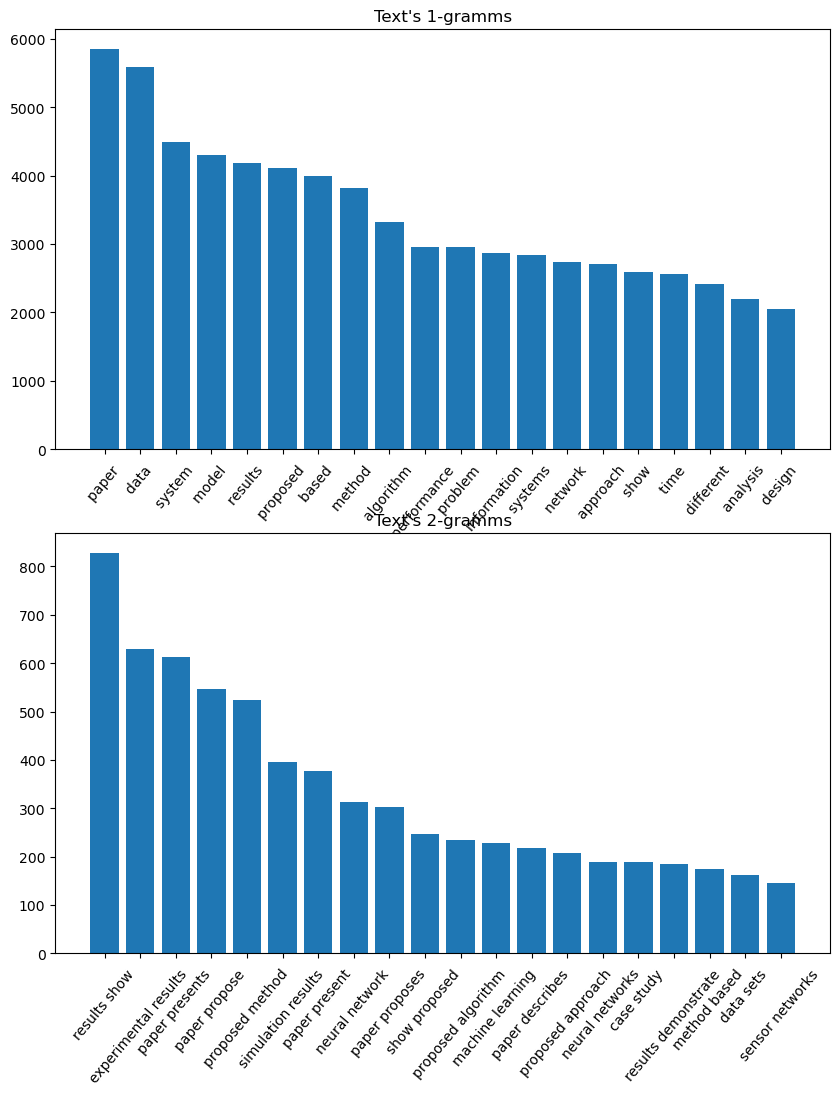

In [12]:
most_common = plot_gramms(data_frame, 20, True)

In [13]:
data_frame = clean_dataframe(data_frame, most_common)

  0%|          | 0/10000 [00:00<?, ?it/s]

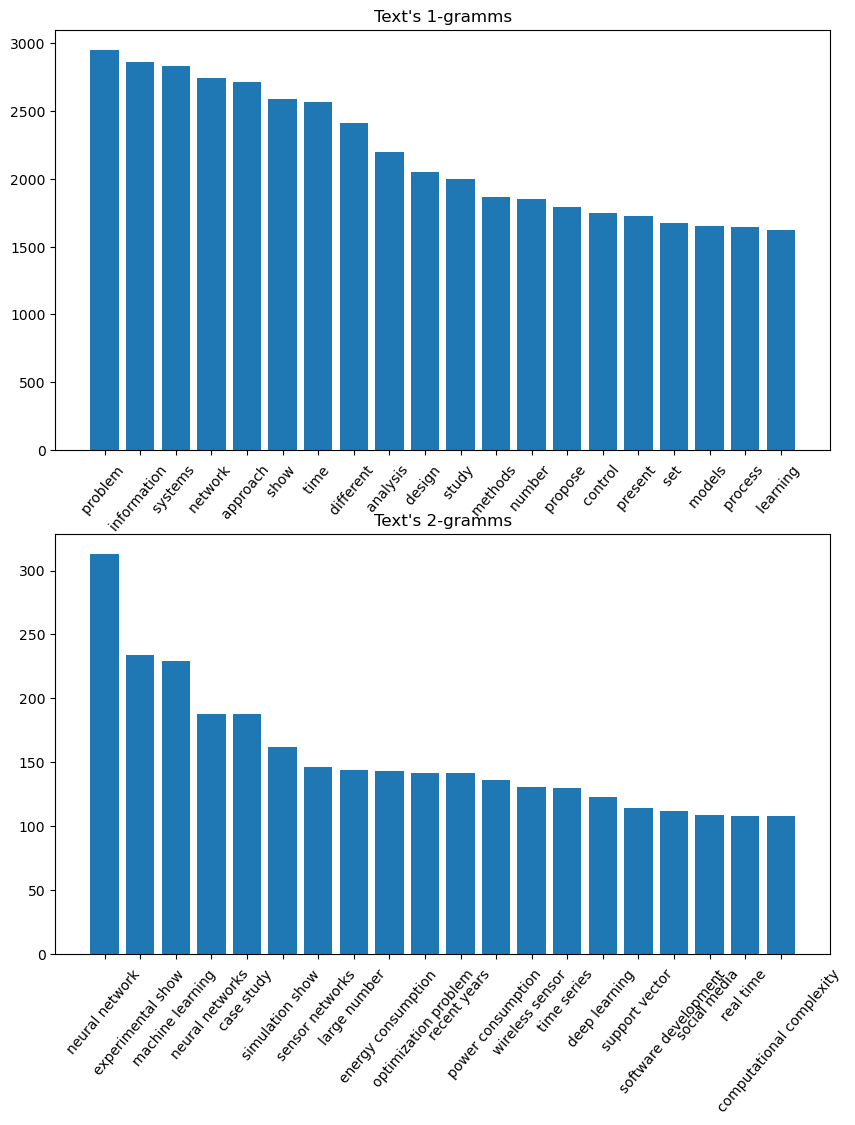

In [14]:
_ = plot_gramms(data_frame, 20, True)

In [15]:
data_frame["vector"] = None
data_frame["labels"] = None
data_frame["vector"].astype(object)
pass

In [16]:
data_frame

,_id,abstract,vector,labels
2500640,573696806e3b12023e58bded,consider distributed dson architecture interac...,None,None
1939546,5550432e45ce0a409eb46401,web applications prevalent platforms informati...,None,None
2451165,573695d36e3b12023e4eb9ff,analysis fuzzyoverlapping community structure ...,None,None
919218,53e9ab78b7602d970351a4a3,approach clustering timeseries approach discov...,None,None
254711,53e99cdfb7602d970259505a,symbolic checking successful technique verifyi...,None,None
...,...,...,...,...
1978007,555046c345ce0a409eb6153b,recently softcast scheme employs analoglike tr...,None,None
2250903,558bdf9be4b02b9f07a3c0c3,describe sensorless visualizing techniques 3d ...,None,None
726111,53e9a757b7602d970308d80b,tool developed structured detailed analysis vi...,None,None
3738657,5f1ab58a9fced0a24bde6869,scientists challenges spanning academic nonaca...,None,None


## Word Embeddings

In [17]:
corpus = build_corpus(data_frame)

In [21]:
model = word2vec.Word2Vec(corpus, vector_size=VECTOR_SIZE, window=10, workers=4, min_count=0)

In [22]:
vectorize_abstract(data_frame, corpus, model)
vectors = np.array(list(data_frame["vector"])).reshape(SAMPLES_NUM, VECTOR_SIZE)

## Data clustarization

In [49]:
knn = cluster.KMeans(n_clusters=5, random_state=42).fit(vectors)

labels = knn.labels_
data_frame["labels"] = labels

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 5
Estimated number of noise points: 0


In [50]:
data_frame["labels"].value_counts()

1    2381
4    2375
2    1897
0    1804
3    1543
Name: labels, dtype: int64

## Vizualization

In [51]:
tokens = []
colors = []

unique_labels = pd.unique(data_frame["labels"])
colors_palete = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for i, _id in enumerate(tqdm(data_frame["_id"])):
    vector = np.array(data_frame[data_frame["_id"] == _id]["vector"])[0].flatten()
    tokens.append(vector)

    label = int(data_frame[data_frame["_id"] == _id]["labels"])
#     print(label)
    if label != -1:
        colors.append(colors_palete[label])
#         print(colors_palete[label])
    else:
        colors.append((0, 0, 0, 1))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [52]:
tsne_model = TSNE(perplexity=2, n_components=2, init='pca', n_iter=1000, random_state=23, learning_rate="auto")
new_values = tsne_model.fit_transform(np.array(tokens))

C:\Max\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


  0%|          | 0/10000 [00:00<?, ?it/s]

DROWING STARTED


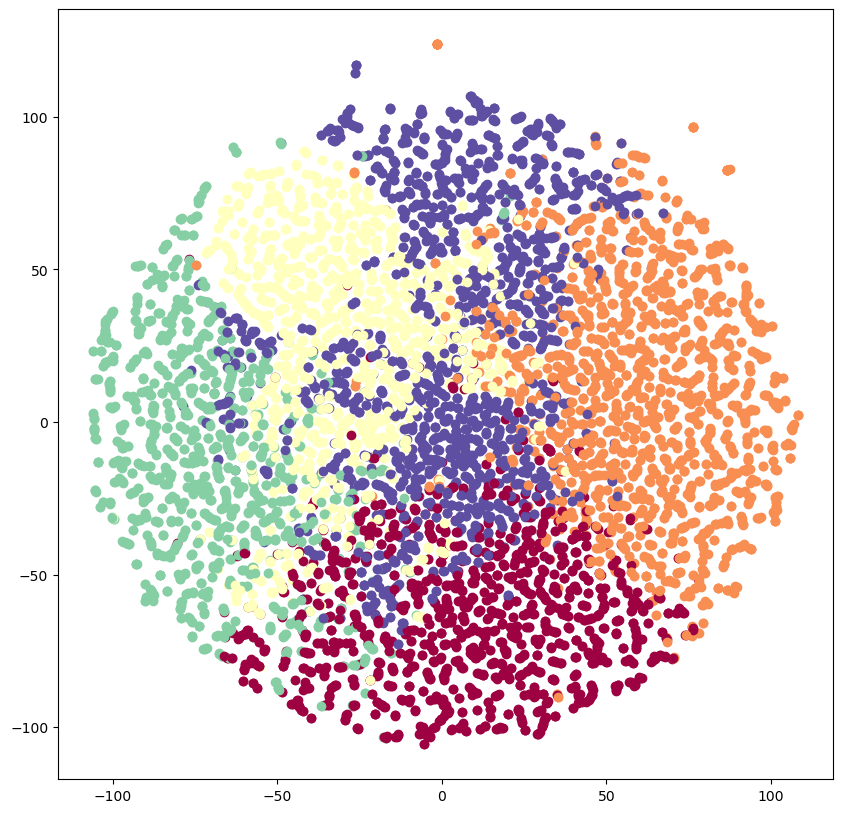

DROWING FINISHED


In [53]:
x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(10, 10)) 
for i in tqdm(range(len(x))):
    plt.scatter(x[i],y[i], color=colors[i])

print("DROWING STARTED")
plt.show()
print("DROWING FINISHED")

In [64]:
for label_i in tqdm(range(n_clusters_)):
    label_frame = data_frame[data_frame["labels"]==label_i]
    vec_frame = label_frame.iloc[0]["vector"].reshape(VECTOR_SIZE)
    print(model.wv.most_similar(positive=(vec_frame), topn=15))
    print()

  0%|          | 0/5 [00:00<?, ?it/s]

[('recovery', 0.9860779643058777), ('encrypt', 0.985424280166626), ('exploiting', 0.9845684766769409), ('advantage', 0.9835796356201172), ('highfrequency', 0.9822605848312378), ('redundancy', 0.9822115302085876), ('drift', 0.981571614742279), ('multichannel', 0.9813745617866516), ('eliminate', 0.9812050461769104), ('adaptively', 0.9803439974784851), ('employs', 0.9797214865684509), ('selective', 0.9793147444725037), ('avs', 0.9791157841682434), ('encoder', 0.9787607789039612), ('adapts', 0.9785110950469971)]

[('multimedia', 0.9880333542823792), ('rapid', 0.9841578602790833), ('offpremises', 0.9819522500038147), ('intercloud', 0.981719970703125), ('exposes', 0.9814233183860779), ('locationbased', 0.9809066653251648), ('increasingly', 0.9807174205780029), ('urgent', 0.9805771112442017), ('technologies', 0.9802924394607544), ('ubiquitous', 0.979025661945343), ('things', 0.9784344434738159), ('nowadays', 0.9784160852432251), ('emerging', 0.9782159328460693), ('major', 0.9777294397354126),

In [55]:
data_frame.sample(10)

,_id,abstract,vector,labels
2457624,573695ec6e3b12023e5019c0,case build contextaware computingbased safety ...,"[[0.007927151], [0.36969152], [0.07603745], [0...",0
1880583,55503e7245ce0a409eb29837,letter kernel collaborative representation tik...,"[[-0.052853297], [0.082205005], [0.18272121], ...",2
2505461,573696956e3b12023e59e011,coexistence wifi zigbee 24 ghz ism band long s...,"[[-0.01750318], [0.35377473], [0.11118436], [0...",0
2172979,558adae2e4b0b32fcb3946eb,achieving desired application software middlew...,"[[0.05400599], [0.29411042], [0.053512294], [0...",1
2547527,573697646e3b12023e64c39e,deals offline allocation lightpaths alloptical...,"[[-0.10372496], [0.30017254], [0.04921468], [0...",3
1053219,53e9ae29b7602d970383aafe,aiming limitations benchmark tools brings bene...,"[[0.054774724], [0.24054252], [-0.073044464], ...",1
2296417,558c4f3ae4b00c3c48e18aa4,proxying simple effective means allowing netwo...,"[[-0.012172229], [0.33899215], [0.07506446], [...",0
1619226,53e9b9e1b7602d97045d9edf,exact form symbol error rate derived zeroforci...,"[[-0.019608114], [0.34150377], [0.21838103], [...",3
373253,53e99f69b7602d970283a874,incremental parsing long recognized technique ...,"[[0.019233048], [0.2476168], [0.025946688], [0...",4
1210112,53e9b16db7602d9703bf66cd,ganbased lightemitting diode led airbuffer lay...,"[[0.009209115], [0.22971077], [0.06961784], [0...",4


In [56]:
data_frame.to_csv("labeled_dataset.csv")

In [62]:
data_frame.dtypes

_id         object
abstract    object
vector      object
labels       int32
dtype: object